Remove warnings:

In [1070]:
import warnings
warnings.filterwarnings('ignore')

Import libraries:

In [1071]:
import pandas as pd
import numpy as np
import quandl
from pymssa import MSSA

import matplotlib.pylab as plt
import seaborn as sns
from tabulate import tabulate

Parameters:

In [1072]:
test_sample = 0.05

MAPE function:

In [1073]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Load daily data from Quandl - choose PEP, MSFT, AAPL: 

In [1074]:
ticker = 'MSFT'
start_date='1999-01-01'
end_date = '2019-12-13'

df = quandl.get('WIKI/%s' % ticker, start_date=start_date, end_date=end_date)
df = df.rename(columns={'Adj. Close': 'close', 'Adj. Volume': 'volume'})
df_close = 100*df['close'].resample('1M').last()

Show time series length:

In [1075]:
print('Length:', len(df_close))

Length: 231


Define increment:

In [1076]:
delta = int(test_sample*len(df_close))

Define train/test sets:

In [1077]:
train_ts = df_close[:(len(df_close)-delta)]
test_ts = df_close[(len(df_close)-delta):]

print('Length of train series:', len(train_ts))
print('Length of test series:', len(test_ts))

Length of train series: 220
Length of test series: 11


Define parameters and fit:

In [1078]:
mssa = MSSA(n_components='parallel_analysis', pa_percentile_threshold=95, window_size=None, verbose=False)
mssa.fit(train_ts)

Number of components:

In [1079]:
print('Number of components:', mssa.components_.shape[2])

Number of components: 2


Components correlation:

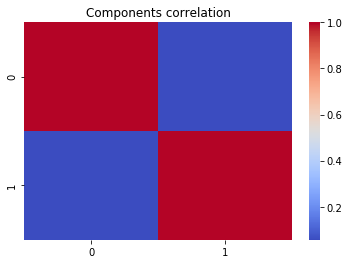

In [1080]:
crl = np.abs(mssa.w_correlation(mssa.components_[0, :, :]))

plt.figure(figsize=(6, 4))
sns.heatmap(np.abs(crl), cmap='coolwarm')

plt.title('Components correlation')
plt.show()

Component explained variance:

In [1081]:
comp_num = len(mssa.component_ranks_explained_variance_.tolist())
print(mssa.component_ranks_explained_variance_.tolist())

[[0.7797496599921541], [0.43583174889159193]]


Make predict:

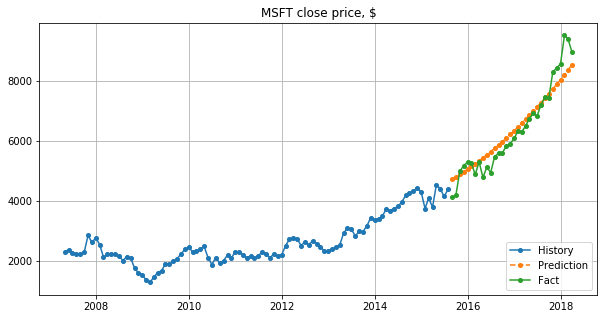

In [1089]:
predict = list(mssa.forecast(delta)[0])

plt.figure(figsize=(10, 5))

plt.plot(train_ts[-100:], '.-', markersize=8, label='History')
plt.plot(test_ts.index, predict, '.--', markersize=8, label='Prediction')
plt.plot(test_ts.index, list(test_ts), '.-', markersize=8, label='Fact')

plt.legend(loc='lower right')
plt.title(str(ticker+' close price, $'))

plt.grid()
plt.show()

Metrics and volumes:

In [1083]:
print('MAPE:', int(round(mape(test_ts, predict))), '%')

MAPE: 4 %


Metrics vs test_size:

In [1084]:
mape_list = []
test_volume = []

for i in range(1, 15):
    
    test_sample = i*0.01
    test_volume.append(test_sample)
    
    delta = int(test_sample*len(df_close))
    train_ts = df_close[:(len(df_close)-delta)]
    test_ts = df_close[(len(df_close)-delta):]
    
    mssa = MSSA(n_components='parallel_analysis', pa_percentile_threshold=95, window_size=None, verbose=False)
    mssa.fit(train_ts)
    mape_list.append(mape(test_ts, list(mssa.forecast(delta)[0])))

Plot metrics:

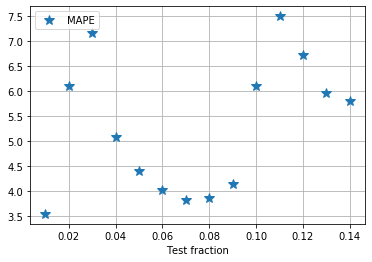

In [1085]:
plt.plot(test_volume, mape_list, '*', markersize=10, label='MAPE')

plt.xlabel('Test fraction')
plt.legend(loc='upper left')

plt.grid()
plt.show()